# PyTorchで LSTM 体験
### LSTMの対象：時系列データ（文章、音声、気温、株価、動き(3軸加速度)など）
### この演習では X軸方向の加速度データ（sin波で単純化した疑似データ）の値をLSTMに予測させる。=次の動きを予測させるようなイメージ
### CPU（ノートPCで十分に計算可能）

```
以下の問に対して、すべての解答をこの.ipynbファイルに入力し、所定のGoogleClassroomに提出しなさい。


【必須】
問1 LSTMについて、用語（RNN、再帰、長期記憶、短期記憶）を用いて簡単に説明しなさい。
問2 シーケンスとは何か、sequentialの意味から説明しなさい。
問3 下記のコードとコメントを参照しながら、予測結果表示までの作業手順（実装方法）を番号付き箇条書きで示しなさい。
問4 シーケンス長を変更し、予測値の精度を上げなさい（2つの曲線がぴったり重なるように）。実際に下記のコードに対してシーケンス長を変更して実行し、予測結果（グラフ）を示すとともに、シーケンス長と精度の関係性について簡単に述べなさい。

【任意】
問5 入力データを下記の例とは異なる波で設定し、実行した結果を示しなさい。
問6 実際の株価や気温などの時系列データを用いて予測結果を示しなさい（ネットや書籍のコードを模倣しても構わない）。
```

【必須】問1　解答欄
```
LSTM（Long Short Term Memory）とはRNN(Recurrent Neural Network)を改良した物である。RNNとは、ニューラルネットワークを拡張して時系列データを扱えるようにした物である。RNNもニューラルネットワークノの一種であるため、入力層、中間層、出力層の三層を持っている。時刻ごとに入出力が発生するという特徴はあるが、入力層と出力層がそれぞれ入力データ、出力結果を持つ点においては、通常のニューラルネットワークと一緒である。
RNNで大きく異なるのは、中間層の構造である。ある時刻の中間層から出力の結果を次の時刻の中間層に伝えている。これによって同じ時刻tの入力層からのデータに加え、前の時刻であるt-1の中間層からのデータも受け取ることとなり再帰していることとなる。 RNNは、中間層の時間経過を配慮しないといけないので単純に誤差逆伝播法を用いることができない。そこで時間経過を表現できるように改良した手法がいくつか提案されている。
RNNは遠い過去の中間層出力を反映させることが難しいので、実際の適応時にはそのままの形では無く、若干の改良を加えたネットワークモデルを利用することが多い。そこでLSTMを用いる。LSTMは神経科学の短期記憶、長期記憶からヒントを経てデザインされたものである。
短期記憶とは、数分程度の一時的な想起は可能であるが、数日経つと忘れてしまう記憶のことである。
長期記憶とは、何年も覚えているような記憶のことである。
LSTMは、RNNの中間層出力に対して記憶期間の長さを導入することで、遠い過去の出力の影響を保持することを可能にしている。そのため、中間層からのデータに忘却ゲートという物を作り、どのデータを通すかを選別している。
```
---

【必須】問2　解答欄
```
sesequentialとは連続（しているもの）、一続き（のもの）、順序、順番、並び、配列（する）、逐次、並べる、順序付ける、などの意味を持つ英単語である。
ITの分野では、順番に並んだ一続きのデータや手順のことや、並んだ順番にデータや手順を取り扱う処理方式などのことを意味する場合が多い。
```
---

【必須】問3　解答欄
```
1:ライブラリのインポート
2:入力データの用意
3:シーケンスの作成
4:訓練データと検証データの作成(学習データと教師データそれぞれに対して)
5:LSTMのモデルに入力するためにデータを前処理する
6:ネットワークモデルの定義
7:ネットワークモデルの実装
8:損失関数と最適化関数の定義
9:ネットワークモデルの学習
```
---

【必須】問4　解答欄
```
今回、シーケンス長を30と60と120と200と498で試してみた結果、30と60では近づいて、120で最も近づいた。２００ではそこからすこしづれ、498では完璧に外れた。その結果から、x軸がシークエンス長、y軸が精度だとすると放物線のようなグラフになる。
```
---

## ライブラリのインポート

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn') # すべてのグラフに縦線を入れたかったので
%matplotlib inline

## 入力データの用意

```今回は例として、X軸方向の加速度データ【sin波で単純化した疑似データ】を自作 ```

In [2]:
# 入力データとしてsin波を設定
t = np.linspace(0, 499, 500) # 時刻t：0〜499まで1刻みで設定
x_acc = np.sin(t * np.pi / 50)

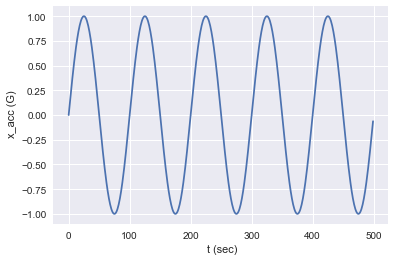

In [3]:
plt.grid(linewidth=1)
plt.ylabel(' x_acc (G)') # X軸方向の加速度と想定
plt.xlabel(' t (sec)') # 時間軸と想定
plt.plot(t, x_acc);

## シーケンスの作成　（学習データと教師データのそれぞれに対して）
``` LSTMのモデルを利用するためには入力データを一定長のデータ＝シーケンスに変換する必要がある ```

``` 下記の例では シーケンス長を10に設定（10秒間隔で切り出したデータと想定）```

In [4]:
# 入力データ：x_acc = np.sin(x * np.pi / 50)

#######################################

seq_length = 120 # シーケンス長を 10 に設定 
                # 検証データ数を10とするとき シーケンス長のMaxは489
#######################################

input_length = len(x_acc)

input_seq_data = [] # 学習データのシーケンス格納用配列
teaching_seq_data = [] # 教師データのシーケンス格納用配列

for i in range(input_length - seq_length): # 500の全データから10のシーケンス長を引いた「490」回繰り返す
    input_seq_data.append( x_acc[ i : i+seq_length])
    # 入力データ「x_acc」に対して、シーケンス分「10個」のデータを切り出し、配列に追加していく
    # i=0  1回目：x_acc[0]からx_acc[9]までの値をinput_seq_data配列に追加
    # i=1  2回目：x_acc[1]からx_acc[10]までの　　　　 〃  
    # ・・・
    # i=489 490回目：x_acc[489]からx_acc[499]までの　〃  
    
    teaching_seq_data.append( x_acc[ i+seq_length : i+seq_length+1]) 
    # 教師データには学習データのシーケンス分だけ先「10個先」のデータを格納
    # i=0：  x_acc[10]からx_acc[11]までの値をinput_seq_data配列に追加
    # i=1：  x_acc[11]からx_acc[12]までの   　     〃  
    # ・・・
    # i=489：x_acc[499]からx_acc[500]までの　      〃

# numpy 配列に変換
np_arr_input = np.array(input_seq_data)
np_arr_teach = np.array(teaching_seq_data)

print('学習データ：', np_arr_input.shape)
# シーケンス長=10なので10刻みでデータが格納されている
# 490行 x 10列 のデータ（1行あたり10個のデータが格納されている）

print('教師データ：', np_arr_teach.shape)
# 490行 x 1列 のデータ（１行あたり１個のデータが格納されている）

学習データ： (380, 120)
教師データ： (380, 1)


## 訓練データと検証データの作成　（学習データと教師データのそれぞれに対して）

In [5]:
#検証データ数を設定
num_test = 10

# 学習データについて
# 訓練データを作成（全490行のうち、先頭から480行を訓練データとする）
input_seq_train = np_arr_input[:-num_test] # 下の処理を簡略化した書き方
#input_seq_train = np_arr_input[0:len(np_arr_input)-num_test]

# 検証データを作成（全490行のうち、下から10行を検証データとする）
input_seq_test = np_arr_input[-num_test:]



# 教師データについて
# 訓練データを作成（全490行のうち、先頭から480行を訓練データとする）
teach_seq_train = np_arr_teach[:-num_test] # 下の処理を簡略化した書き方
#teach_seq_train = np_arr_teach[0:len(np_arr_teach)-num_test]

# 検証データを作成（全490行のうち、下から10行を検証データとする）
teach_seq_test = np_arr_teach[-num_test:]

print(input_seq_train.shape) # 480行 x 10列 のデータ
print(input_seq_test.shape)  #  10列 x 10列 のデータ
print(teach_seq_train.shape) # 480行 x  1列 のデータ
print(teach_seq_test.shape)  #  10列 x  1列 のデータ
# 全部で490個あったデータから最初の480を訓練データ、残りの10個を検証データに分けたことを確認できる

(370, 120)
(10, 120)
(370, 1)
(10, 1)


## LSTMのモデルに入力するためにデータを前処理する
``` LSTMへの入力形式（シーケンス長、バッチサイズ、入力次元）```

``` 今回はバッチサイズ＝訓練データ数（つまり480）```

``` 入力次元は x_acc だけなので 1次元 ```

In [6]:
# 32bitの浮動小数点数型tensorに変換する
train_t = torch.FloatTensor(input_seq_train)
teach_t = torch.FloatTensor(teach_seq_train)

print(train_t.size())
print(teach_t.size())
# Tensor型に変換されていることを確認、データ数、シーケンス長の順番で格納されている

torch.Size([370, 120])
torch.Size([370, 1])


In [7]:
# 列の順番を入れ替える　シーケンス長を1番目最初に移動する
seq_train_t = train_t.permute(1, 0)
seq_teach_t = teach_t.permute(1, 0)

print(seq_train_t.size())
print(seq_teach_t.size())

torch.Size([120, 370])
torch.Size([1, 370])


In [8]:
# ３つ目の軸、入力次元数を設定するために unsquesszeを用いて　一番最後に1を付与する
train_data = seq_train_t.unsqueeze(dim= -1)
teach_data = seq_teach_t.unsqueeze(dim= -1)

print(train_data.size())
print(teach_data.size())

torch.Size([120, 370, 1])
torch.Size([1, 370, 1])


## ネットワークモデルの定義

In [9]:
# LSTMは全結合(Linear)層とセットで使用する

class LSTM(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()

        self.hidden_size = hidden_size
        # input_size：入力次元 シーケンス長：10、1次元データ        
        self.lstm = nn.LSTM(input_size=1, hidden_size=self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, 1)
    def forward(self, x):
        x, _ = self.lstm(x) # 2つの値が返ってくる：出力値(シーケンス)、隠れ層やセルの状態がタプル型でまとまったもの
                            # xに格納される1つ目の出力値だけを用いる。２つ目の返り値は不要なので変数を用意しない（メモリ節約）
        print(len(x))
        x_last = x[-1] # 出力値(シーケンス)の一番最後の値だけを取り出す
        x = self.linear(x_last) 
        return x

## ネットモデルの実装

In [10]:
# モデルの実装　隠れ層のサイズを100として実装
model = LSTM(100)

## 損失関数と最適化関数を定義する（設定する）

In [11]:
criterion = nn.MSELoss() # 損失関数として回帰問題用のMSEを用いる
optimizer = optim.Adam(model.parameters(), lr=0.001) # 最適化関数のAdamを用いる

## ネットワークモデルの学習

In [12]:
num_epochs = 100
losses = []
for epoch in range(num_epochs):
    # 今回はミニバッチ学習ではなく、バッチ学習なので最適化関数の初期化から始める
    optimizer.zero_grad()
    output = model(train_data)
    loss = criterion(output, teach_data)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    print("epoch: {}, loss: {}".format(epoch, loss.item()))

120


/Users/sawda/.local/share/virtualenvs/torch-c2AwxiQJ/lib/python3.7/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1, 370, 1])) that is different to the input size (torch.Size([370, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0, loss: 0.5243183970451355
120
epoch: 1, loss: 0.5115536451339722
120
epoch: 2, loss: 0.498826265335083
120
epoch: 3, loss: 0.48603564500808716
120
epoch: 4, loss: 0.47305527329444885
120
epoch: 5, loss: 0.45974451303482056
120
epoch: 6, loss: 0.44595086574554443
120
epoch: 7, loss: 0.4315073788166046
120
epoch: 8, loss: 0.41622668504714966
120
epoch: 9, loss: 0.399895578622818
120
epoch: 10, loss: 0.3822634220123291
120
epoch: 11, loss: 0.36302876472473145
120
epoch: 12, loss: 0.3418225347995758
120
epoch: 13, loss: 0.31820380687713623
120
epoch: 14, loss: 0.29167959094047546
120
epoch: 15, loss: 0.2617904543876648
120
epoch: 16, loss: 0.2283792793750763
120
epoch: 17, loss: 0.1923784762620926
120
epoch: 18, loss: 0.15804365277290344
120
epoch: 19, loss: 0.13816073536872864
120
epoch: 20, loss: 0.14504374563694
120
epoch: 21, loss: 0.14800189435482025
120
epoch: 22, loss: 0.1330074667930603
120
epoch: 23, loss: 0.11202049255371094
120
epoch: 24, loss: 0.09631487727165222
120
e

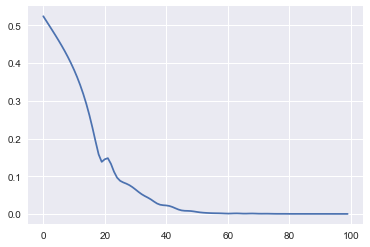

In [13]:
plt.plot(losses)

In [14]:
# 訓練データのときと同様に Tensor変換、列の入れ替え、次元の追加をおこなう
test_data = torch.FloatTensor(input_seq_test)
test_data = test_data.permute(1, 0)
test_data = test_data.unsqueeze(dim=-1)
test_data.size()

torch.Size([120, 10, 1])

In [15]:
x_acc_pred = model(test_data)
x_acc_pred.size()

120


torch.Size([10, 1])

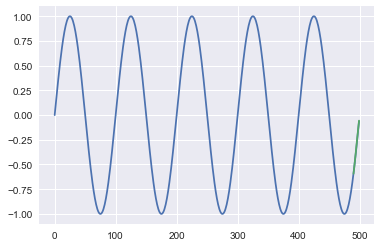

In [16]:
# まずは全体を表示　x = 490 〜 500 の一致度を確認　緑色が予測線
plt.plot(t, x_acc)
plt.plot(np.arange(490, 500), x_acc_pred.detach())

(450.0, 500.0)

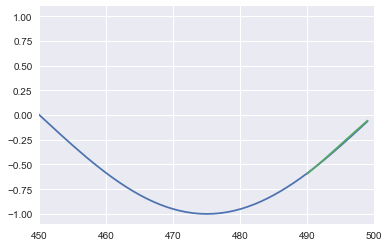

In [17]:
# 一致度を分かりやすくするために450-500付近を拡大表示

plt.plot(t, x_acc)
plt.plot(np.arange(490, 500), x_acc_pred.detach())
plt.xlim([450, 500])

【必須】問5 入力データを下記の例とは異なる波で設定し、実行した結果を示しなさい。 解答欄


In [2]:
# 入力データとしてsin波を設定
t = np.linspace(0, 499, 500) # 時刻t：0〜499まで1刻みで設定
x_acc = np.sin(t * np.pi / 200)

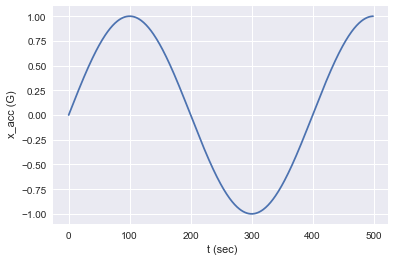

In [3]:
plt.grid(linewidth=1)
plt.ylabel(' x_acc (G)') # X軸方向の加速度と想定
plt.xlabel(' t (sec)') # 時間軸と想定
plt.plot(t, x_acc);

In [4]:
# 入力データ：x_acc = np.sin(x * np.pi / 50)

#######################################

seq_length = 200 # シーケンス長を 10 に設定 
                # 検証データ数を10とするとき シーケンス長のMaxは489
#######################################

input_length = len(x_acc)

input_seq_data = [] # 学習データのシーケンス格納用配列
teaching_seq_data = [] # 教師データのシーケンス格納用配列

for i in range(input_length - seq_length): # 500の全データから10のシーケンス長を引いた「490」回繰り返す
    input_seq_data.append( x_acc[ i : i+seq_length])
    # 入力データ「x_acc」に対して、シーケンス分「10個」のデータを切り出し、配列に追加していく
    # i=0  1回目：x_acc[0]からx_acc[9]までの値をinput_seq_data配列に追加
    # i=1  2回目：x_acc[1]からx_acc[10]までの　　　　 〃  
    # ・・・
    # i=489 490回目：x_acc[489]からx_acc[499]までの　〃  
    
    teaching_seq_data.append( x_acc[ i+seq_length : i+seq_length+1]) 
    # 教師データには学習データのシーケンス分だけ先「10個先」のデータを格納
    # i=0：  x_acc[10]からx_acc[11]までの値をinput_seq_data配列に追加
    # i=1：  x_acc[11]からx_acc[12]までの   　     〃  
    # ・・・
    # i=489：x_acc[499]からx_acc[500]までの　      〃

# numpy 配列に変換
np_arr_input = np.array(input_seq_data)
np_arr_teach = np.array(teaching_seq_data)

print('学習データ：', np_arr_input.shape)
# シーケンス長=10なので10刻みでデータが格納されている
# 490行 x 10列 のデータ（1行あたり10個のデータが格納されている）

print('教師データ：', np_arr_teach.shape)
# 490行 x 1列 のデータ（１行あたり１個のデータが格納されている）

学習データ： (300, 200)
教師データ： (300, 1)


In [5]:
#検証データ数を設定
num_test = 10

# 学習データについて
# 訓練データを作成（全490行のうち、先頭から480行を訓練データとする）
input_seq_train = np_arr_input[:-num_test] # 下の処理を簡略化した書き方
#input_seq_train = np_arr_input[0:len(np_arr_input)-num_test]

# 検証データを作成（全490行のうち、下から10行を検証データとする）
input_seq_test = np_arr_input[-num_test:]



# 教師データについて
# 訓練データを作成（全490行のうち、先頭から480行を訓練データとする）
teach_seq_train = np_arr_teach[:-num_test] # 下の処理を簡略化した書き方
#teach_seq_train = np_arr_teach[0:len(np_arr_teach)-num_test]

# 検証データを作成（全490行のうち、下から10行を検証データとする）
teach_seq_test = np_arr_teach[-num_test:]

print(input_seq_train.shape) # 480行 x 10列 のデータ
print(input_seq_test.shape)  #  10列 x 10列 のデータ
print(teach_seq_train.shape) # 480行 x  1列 のデータ
print(teach_seq_test.shape)  #  10列 x  1列 のデータ
# 全部で490個あったデータから最初の480を訓練データ、残りの10個を検証データに分けたことを確認できる

(290, 200)
(10, 200)
(290, 1)
(10, 1)


In [6]:
# 32bitの浮動小数点数型tensorに変換する
train_t = torch.FloatTensor(input_seq_train)
teach_t = torch.FloatTensor(teach_seq_train)

print(train_t.size())
print(teach_t.size())
# Tensor型に変換されていることを確認、データ数、シーケンス長の順番で格納されている

torch.Size([290, 200])
torch.Size([290, 1])


In [7]:
# 列の順番を入れ替える　シーケンス長を1番目最初に移動する
seq_train_t = train_t.permute(1, 0)
seq_teach_t = teach_t.permute(1, 0)

print(seq_train_t.size())
print(seq_teach_t.size())

torch.Size([200, 290])
torch.Size([1, 290])


In [8]:
# ３つ目の軸、入力次元数を設定するために unsquesszeを用いて　一番最後に1を付与する
train_data = seq_train_t.unsqueeze(dim= -1)
teach_data = seq_teach_t.unsqueeze(dim= -1)

print(train_data.size())
print(teach_data.size())

torch.Size([200, 290, 1])
torch.Size([1, 290, 1])


In [9]:
# LSTMは全結合(Linear)層とセットで使用する

class LSTM(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()

        self.hidden_size = hidden_size
        # input_size：入力次元 シーケンス長：10、1次元データ        
        self.lstm = nn.LSTM(input_size=1, hidden_size=self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, 1)
    def forward(self, x):
        x, _ = self.lstm(x) # 2つの値が返ってくる：出力値(シーケンス)、隠れ層やセルの状態がタプル型でまとまったもの
                            # xに格納される1つ目の出力値だけを用いる。２つ目の返り値は不要なので変数を用意しない（メモリ節約）
        print(len(x))
        x_last = x[-1] # 出力値(シーケンス)の一番最後の値だけを取り出す
        x = self.linear(x_last) 
        return x

In [10]:
# モデルの実装　隠れ層のサイズを100として実装
model = LSTM(100)

In [11]:
criterion = nn.MSELoss() # 損失関数として回帰問題用のMSEを用いる
optimizer = optim.Adam(model.parameters(), lr=0.001) # 最適化関数のAdamを用いる

In [12]:
num_epochs = 100
losses = []
for epoch in range(num_epochs):
    # 今回はミニバッチ学習ではなく、バッチ学習なので最適化関数の初期化から始める
    optimizer.zero_grad()
    output = model(train_data)
    loss = criterion(output, teach_data)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    print("epoch: {}, loss: {}".format(epoch, loss.item()))

200


/Users/sawda/.local/share/virtualenvs/torch-c2AwxiQJ/lib/python3.7/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1, 290, 1])) that is different to the input size (torch.Size([290, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0, loss: 0.5427303910255432
200
epoch: 1, loss: 0.5181577205657959
200
epoch: 2, loss: 0.4942426085472107
200
epoch: 3, loss: 0.47078025341033936
200
epoch: 4, loss: 0.44759589433670044
200
epoch: 5, loss: 0.42450350522994995
200
epoch: 6, loss: 0.4012828469276428
200
epoch: 7, loss: 0.3776814043521881
200
epoch: 8, loss: 0.3534267842769623
200
epoch: 9, loss: 0.3282490670681
200
epoch: 10, loss: 0.30191290378570557
200
epoch: 11, loss: 0.27429232001304626
200
epoch: 12, loss: 0.24559104442596436
200
epoch: 13, loss: 0.2169763445854187
200
epoch: 14, loss: 0.1924695074558258
200
epoch: 15, loss: 0.1840629279613495
200
epoch: 16, loss: 0.20449773967266083
200
epoch: 17, loss: 0.19510780274868011
200
epoch: 18, loss: 0.16617120802402496
200
epoch: 19, loss: 0.14499343931674957
200
epoch: 20, loss: 0.13409484922885895
200
epoch: 21, loss: 0.12814414501190186
200
epoch: 22, loss: 0.12311725318431854
200
epoch: 23, loss: 0.11690967530012131
200
epoch: 24, loss: 0.1085328683257103
200

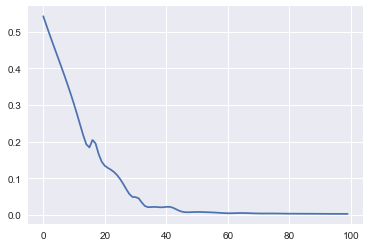

In [13]:
plt.plot(losses)

In [14]:
# 訓練データのときと同様に Tensor変換、列の入れ替え、次元の追加をおこなう
test_data = torch.FloatTensor(input_seq_test)
test_data = test_data.permute(1, 0)
test_data = test_data.unsqueeze(dim=-1)
test_data.size()

torch.Size([200, 10, 1])

In [15]:
x_acc_pred = model(test_data)
x_acc_pred.size()

200


torch.Size([10, 1])

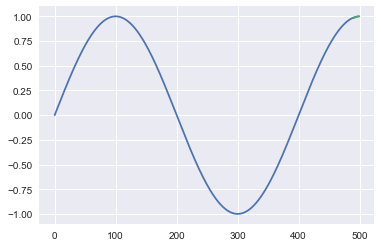

In [16]:
# まずは全体を表示　x = 490 〜 500 の一致度を確認　緑色が予測線
plt.plot(t, x_acc)
plt.plot(np.arange(490, 500), x_acc_pred.detach())

(450.0, 500.0)

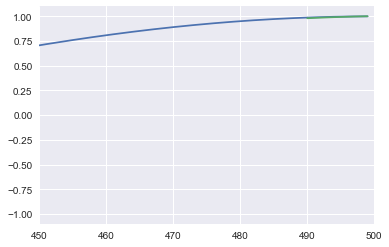

In [17]:
# 一致度を分かりやすくするために450-500付近を拡大表示

plt.plot(t, x_acc)
plt.plot(np.arange(490, 500), x_acc_pred.detach())
plt.xlim([450, 500])